# Auto Encoder with MNIST (or Fashion MNIST)

* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)

## Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

sys.path.append(os.path.dirname(os.path.abspath('.')))
from utils.image_utils import *
from utils.ops import *

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/scpark/anaconda3/envs/ai/lib/python3.7/site-packages

## Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'ae'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'fashion_mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 30
save_model_epochs = 5
print_steps = 1000
save_images_epochs = 1
batch_size = 128
learning_rate = 1e-4
num_examples_to_generate = 16
x_dim = 784
latent_dim = 200

## Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), (test_images, test_labels) = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), (test_images, test_labels) = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, x_dim).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

test_images = test_images.reshape(-1, x_dim).astype('float32')
#test_images = test_images / 255. # Normalize the images to [0, 1]
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

4423680/4422102 [==============================] - 1s 0us/step


## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.set_random_seed(219)

# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.shuffle(buffer_size=N)
test_dataset = test_dataset.batch(batch_size=num_examples_to_generate)
print(test_dataset)

<BatchDataset shapes: (None, 784), types: tf.float32>
<BatchDataset shapes: (None, 784), types: tf.float32>


## Create the AutoEncoder models

In [5]:
class AutoEncoder(tf.keras.Model):
  """Build a autoencoder model."""
  def __init__(self, latent_dim=latent_dim, x_dim=x_dim):
    super(AutoEncoder, self).__init__()
    self.fc1 = layers.Dense(units=latent_dim, activation='relu')
    self.fc2 = layers.Dense(units=x_dim, activation='tanh')

  def call(self, inputs):
    """Run the model."""
    fc1 = self.fc1(inputs)
    fc2 = self.fc2(fc1)
    
    return fc2

In [6]:
ae = AutoEncoder()

## Define the loss functions and the optimizer

In [7]:
def mse_loss(targets, predictions):
  mse_loss = tf.reduce_mean(tf.reduce_sum((predictions - targets)**2, axis=1))
  return mse_loss

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

## Checkpoints (Object-based saving)

In [9]:
checkpoint_dir = train_dir
if not tf.io.gfile.exists(checkpoint_dir):
  tf.io.gfile.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, ae=ae)

## Training

In [10]:
# keeping the random image constant for generation (prediction) so
# it will be easier to see the improvement of the autoencoder.
for inputs in test_dataset.take(1):
  constant_test_input = inputs

### Define training one step function

In [11]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  with tf.GradientTape() as tape:
    reconstruction = ae(images)
    loss = mse_loss(images, reconstruction)
      
  gradients = tape.gradient(loss, ae.trainable_variables)
  optimizer.apply_gradients(zip(gradients, ae.trainable_variables))
  
  return loss

### Train full steps

This images are saved at 20 epoch


KeyboardInterrupt: 

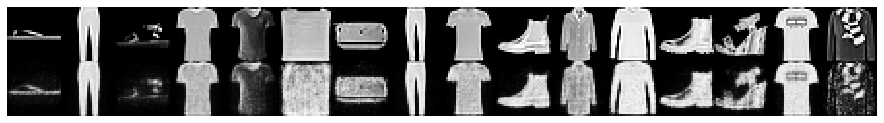

In [12]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)

for epoch in range(max_epochs):
  
  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    loss = train_step(images)
    global_step.assign_add(1)
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} loss: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), loss, examples_per_sec, duration))
      
      for images in test_dataset.take(1):
        sample_images = ae(images)
      print_or_save_sample_images_two(images.numpy(),
                                      sample_images.numpy(),
                                      num_examples_to_generate)

  if (epoch + 1) % save_images_epochs == 0:
    display.clear_output(wait=True)
    print("This images are saved at {} epoch".format(epoch+1))
    sample_images = ae(constant_test_input)
    print_or_save_sample_images_two(constant_test_input.numpy(),
                                    sample_images.numpy(),
                                    num_examples_to_generate,
                                    is_save=True, epoch=epoch+1,
                                    checkpoint_dir=checkpoint_dir)

  # saving (checkpoint) the model every save_epochs
  if (epoch + 1) % save_model_epochs == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)
    
print('Training Done.')

In [ ]:
# generating after the final epoch
display.clear_output(wait=True)
sample_images = ae(constant_test_input)
print_or_save_sample_images_two(constant_test_input.numpy(),
                                sample_images.numpy(),
                                num_examples_to_generate,
                                is_save=True, epoch=epoch+1,
                                checkpoint_dir=checkpoint_dir)

## Restore the latest checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Display an image using the epoch number

In [ ]:
display_image(max_epochs, checkpoint_dir=checkpoint_dir)

## Generate a GIF of all the saved images.

In [ ]:
filename = model_name + '_' + dataset_name + '.gif'
generate_gif(filename, checkpoint_dir)

In [ ]:
display.Image(filename=filename + '.png')